<a href="https://colab.research.google.com/github/Jona163/TUMOR_BRAIN/blob/main/TUMOR_BRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBERIAS A IMPORTAR

In [7]:
import os
import glob
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import skimage.io as io
import tensorflow as tf
from tensorflow.keras import layers, optimizers, backend as K
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from google.colab import files

%matplotlib inline


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
# Lista el contenido dentro de la carpeta 'Colab Notebooks'
os.listdir('/content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/')

['data.csv',
 'data_mask.csv',
 'weights.hdf5',
 'resnet-50-MRI.json',
 'weights_seg.hdf5',
 'ResUNet-MRI.json',
 'utilities.py',
 '.DS_Store',
 '._TCGA_CS_6667_20011105',
 '._TCGA_DU_8164_19970111',
 '._TCGA_DU_8168_19970503',
 '._TCGA_DU_7300_19910814',
 '._TCGA_HT_7475_19970918',
 '._TCGA_DU_7010_19860307',
 '._TCGA_FG_6688_20020215',
 '._TCGA_DU_8167_19970402',
 '._TCGA_DU_7304_19930325',
 '._TCGA_HT_7684_19950816',
 '._TCGA_DU_5871_19941206',
 '._TCGA_HT_8105_19980826',
 '._TCGA_DU_6401_19831001',
 '._TCGA_FG_6692_20020606',
 '._TCGA_HT_A616_19991226',
 '._.DS_Store',
 '._TCGA_FG_7634_20000128',
 '._TCGA_DU_7306_19930512',
 '._TCGA_DU_A5TP_19970614',
 '._TCGA_HT_8113_19930809',
 '._TCGA_HT_7605_19950916',
 '._TCGA_DU_A5TY_19970709',
 '._TCGA_HT_7860_19960513',
 '._TCGA_HT_8114_19981030',
 '._TCGA_DU_8165_19970205',
 '._data_mask.csv',
 '._TCGA_DU_A5TW_19980228',
 '._TCGA_DU_6400_19830518',
 '._TCGA_HT_7608_19940304',
 '._TCGA_HT_8563_19981209',
 '._TCGA_HT_7884_19980913',
 '._TCGA

In [10]:
%cd /content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/

/content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI


In [11]:
# Cargamos los puntos faciales clave
brain_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/data_mask.csv')

In [12]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [13]:
brain_df.head(50)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [14]:
 brain_df.mask_path[1] #ruta a la imagen MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [15]:
 brain_df.image_path[1] #ruta a la imagen MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

# MINI RETO #1
¿Tenemos un dataset balanceado?
¿Cuantas muestras estan marcadas como pacientes sano?

In [16]:
brain_df['mask'].value_counts()

,count
mask,
0,2556
1,1373


In [17]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [18]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [19]:
# usaremos ploty para hacer un diagrama de barras interactivas
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, y=brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)', marker_line_color='rgb(0,255,0)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

In [20]:
brain_df.mask_path

,mask_path
0,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
...,...
3924,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...


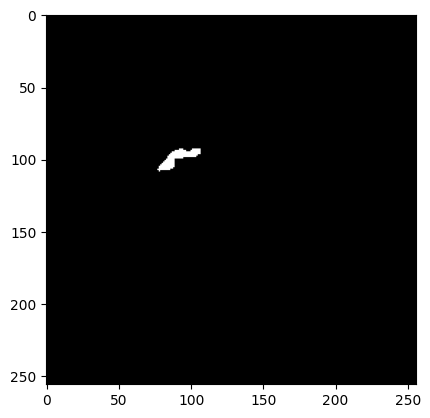

In [21]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

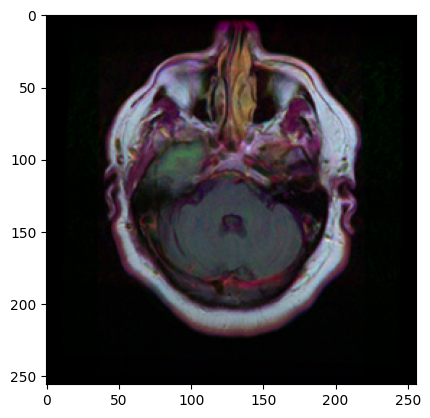

In [22]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [23]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [24]:
cv2.imread(brain_df.image_path[623]).min()

0

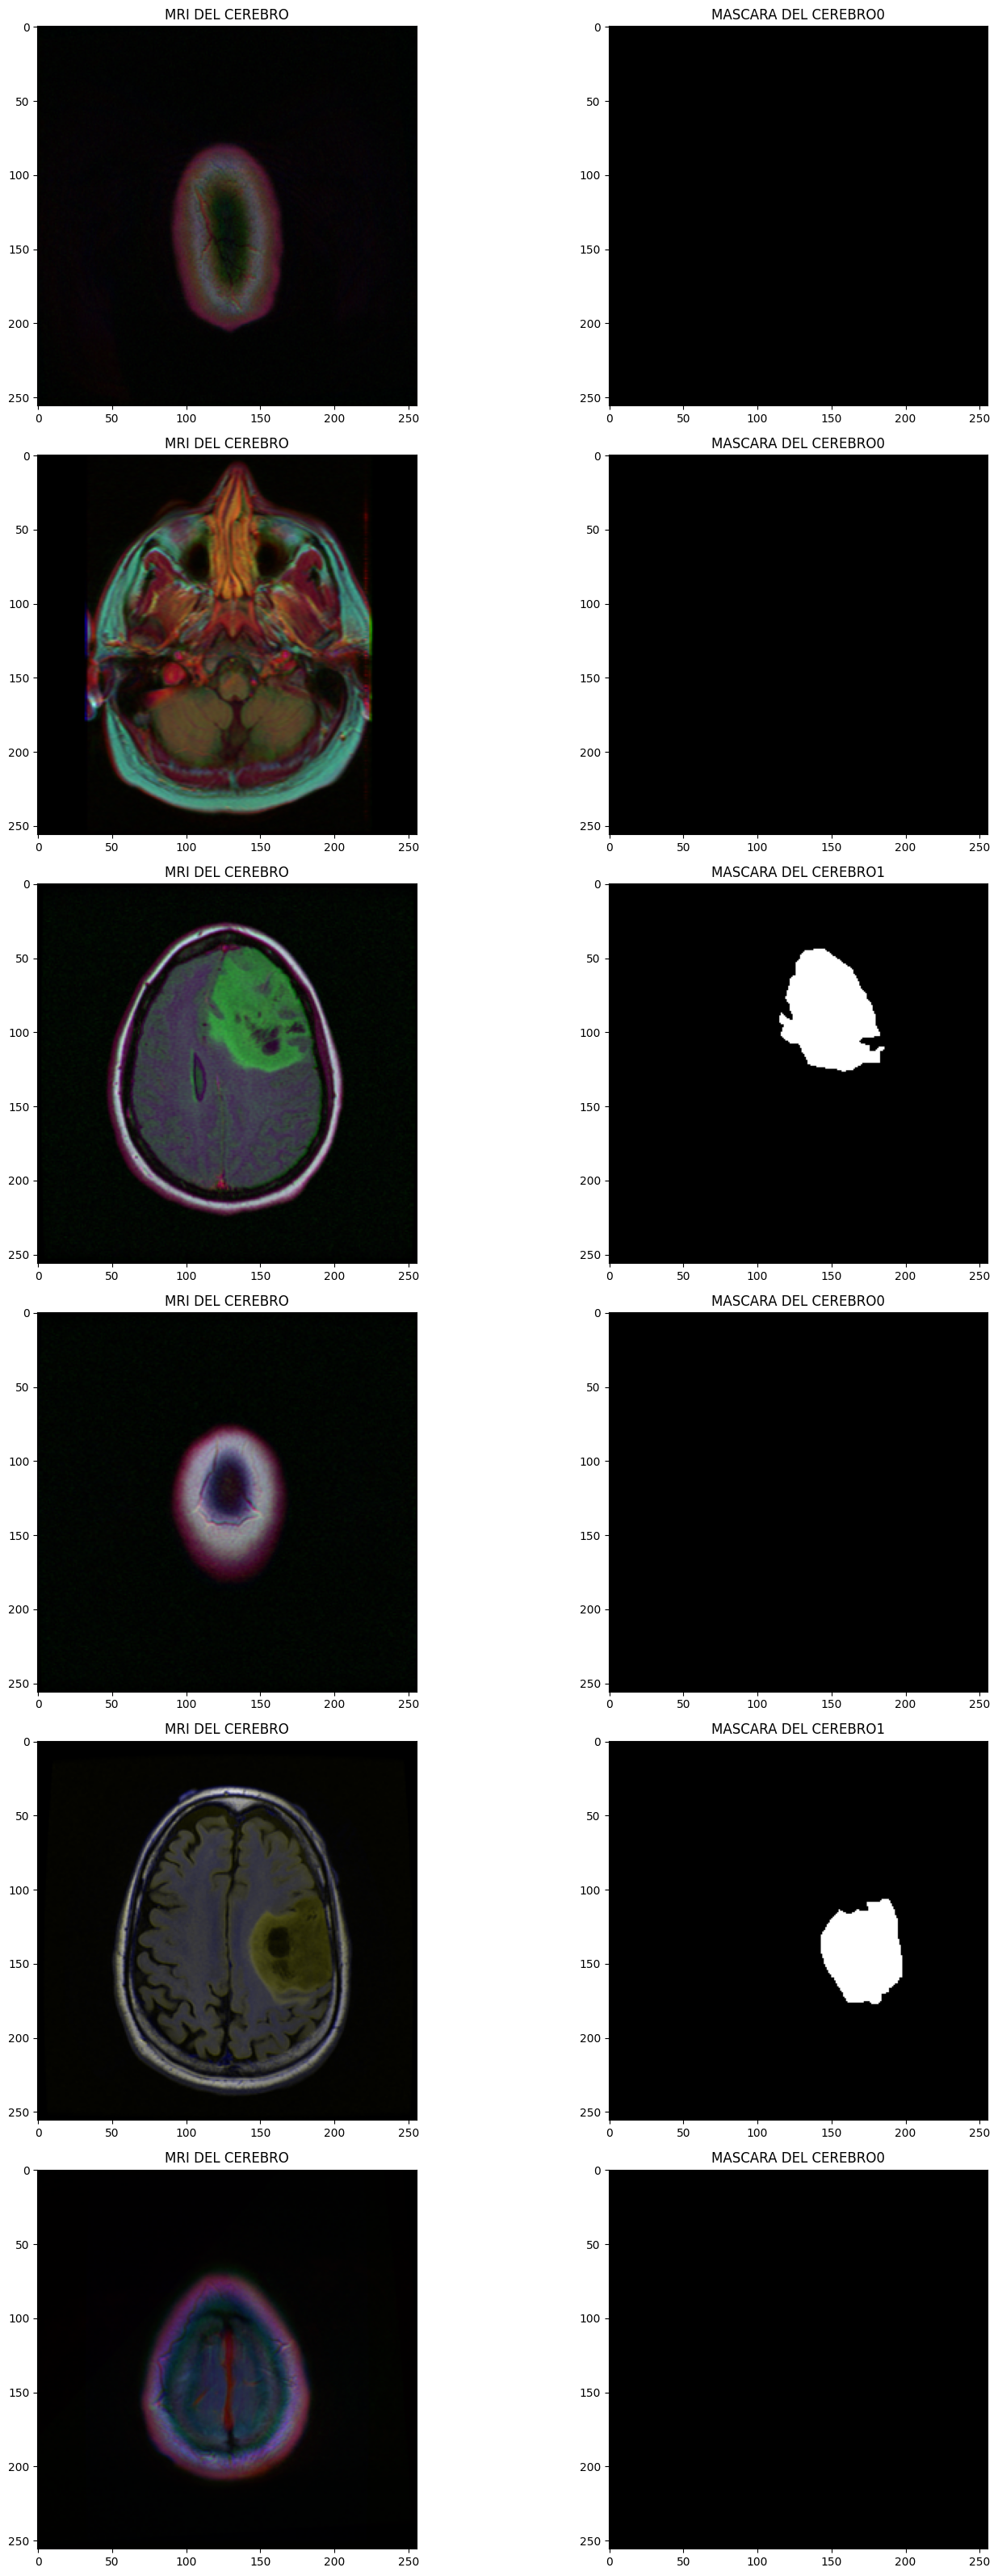

In [25]:
# visualizacion basica  vizualizaremos imagenes (MRI y Mascaras) en el dataset de forma separada.
import random
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("MRI DEL CEREBRO")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("MASCARA DEL CEREBRO" +str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout()

MINI RETO 2#
REPRESENTAR ALEATORIAMENTE 12(1) IMAGENES DE MRI SELECCIONADAS ALEATORIAMENTE DE ENTRE LOS PACIENTES ENFERMOS SEGUIDAS DE (2) SU CORRESPONDIENTE MASCARA(3) TANTO LA IMAGEN DE LA MRI JUNTO CON SU MASCARA (DE COLOR ROJO) UNA ENCIMA DE LA OTRA.

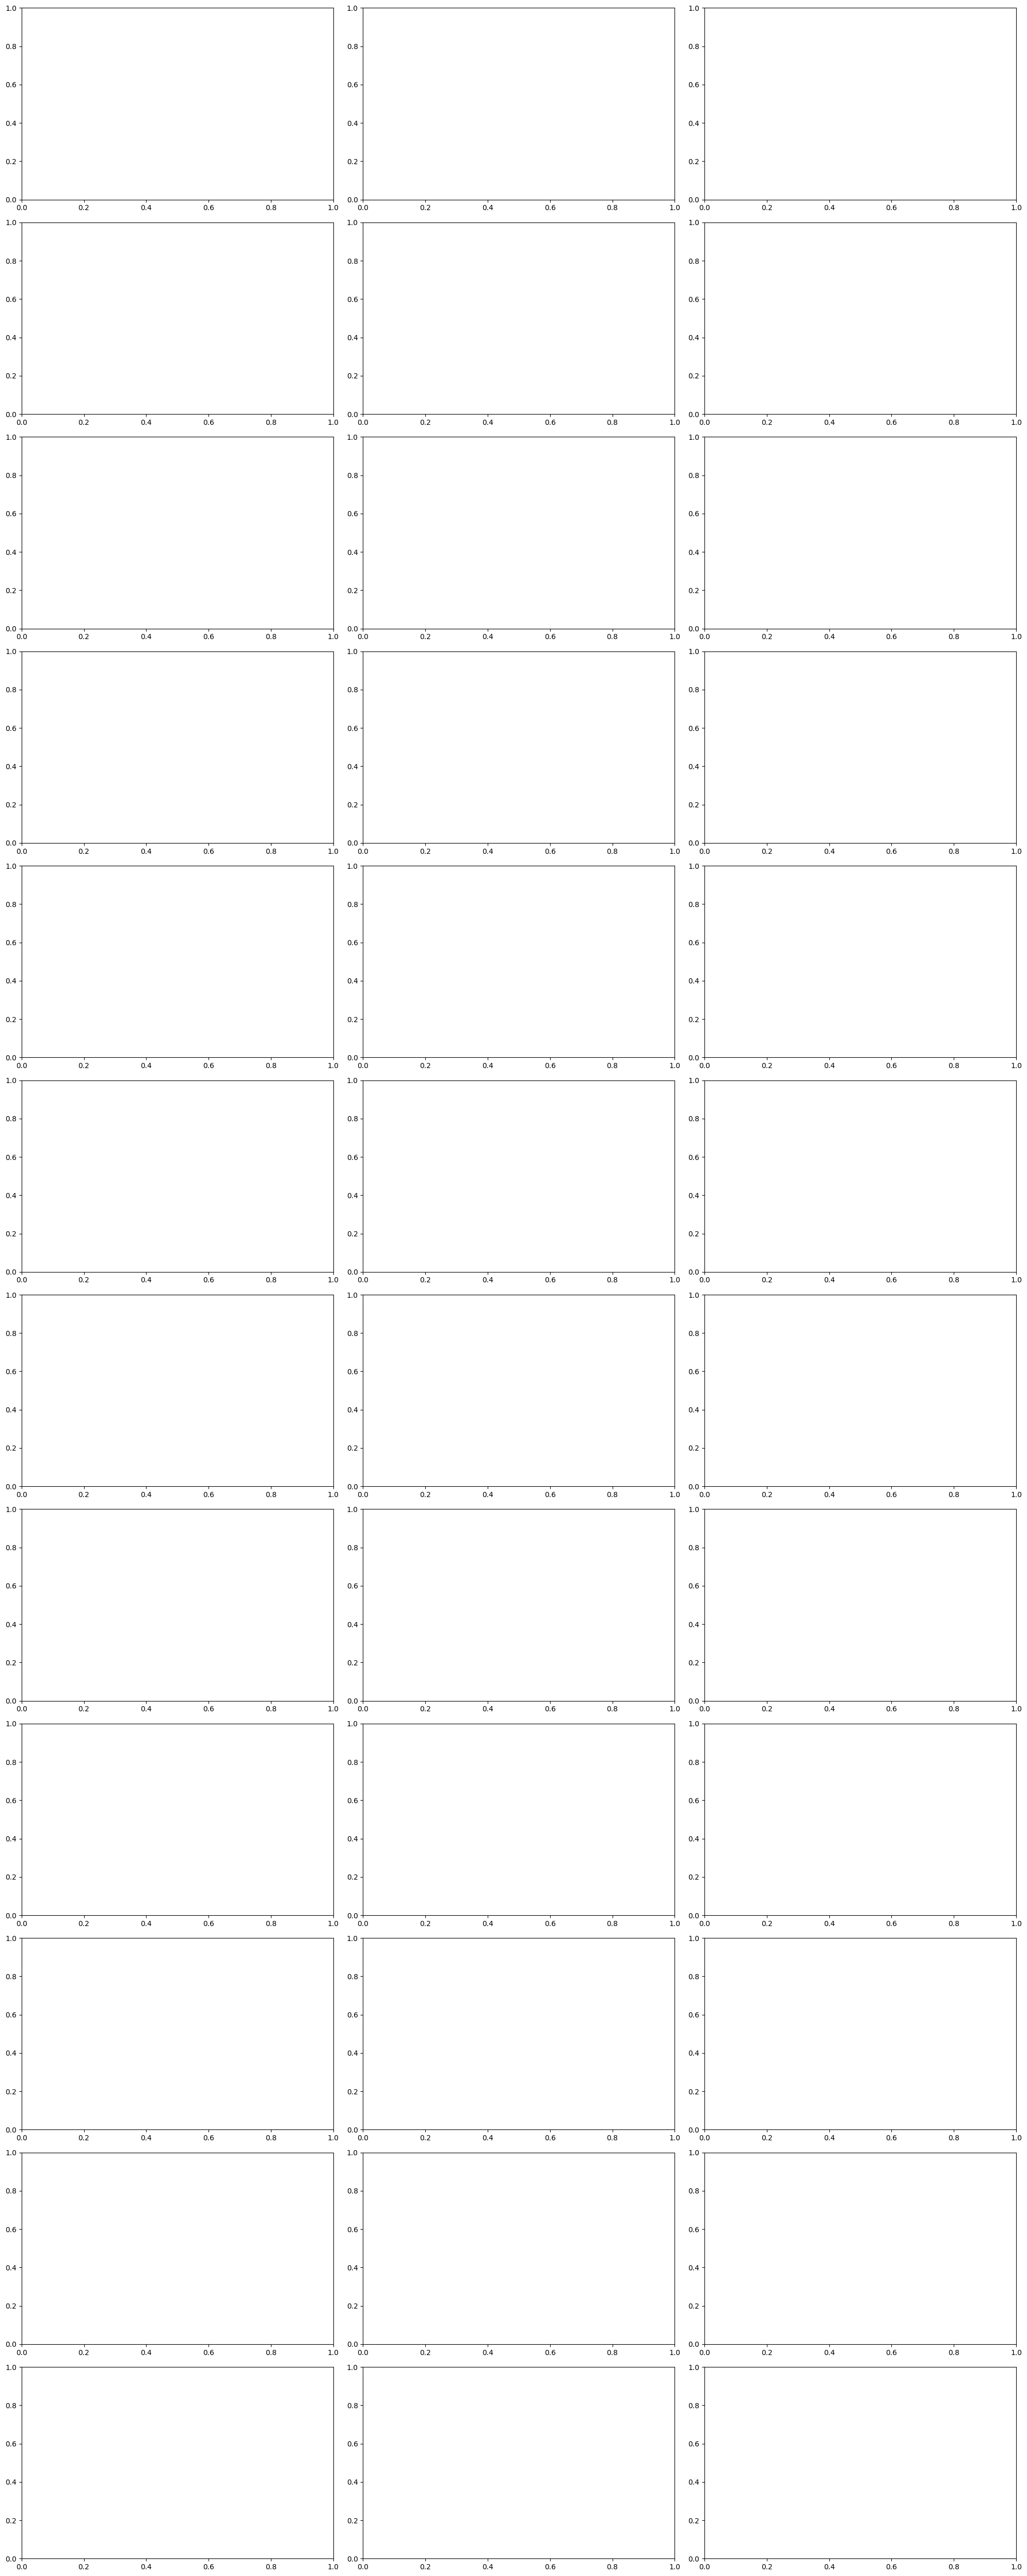

In [26]:
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][1] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text("MRI DEL CEREBRO")
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("MASCARA DEL CEREBRO")
    axs[count][1].imshow(mask, cmap='gray')

    img[mask ==255] = (255,0,0)
    axs[count][2].title.set_text("MRI CON MASCARA ROJA")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

RETO #3:
¿CUAL ES EL RENDIMIENTO DE RESNET EN EL CONJUNTO DE DATOS IMAGENET?
EXPLORA OTRAS ARQUITECTURAS DE RNC COMO ALEXNET Y ENUMERA SU RENDIMIENTO EN COMPARACION CON RESNET (SE REQUIERE EXTERNA)

TAREA #4 ENTENDER LA TEORIA Y LA INTUICION DETRAS DE LAS REDES NEURONALES Y RESNETS CONVOLUCIONALES.